In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [2]:
import tensorflow_addons as tfa

In [3]:
def load_training_data(root_dir):
    data = {}
    data['times']                  = np.load(os.path.join(f'{root_dir}', 'times.npy'))
    data['data_processing_params'] = np.load(os.path.join(f'{root_dir}', 'data_processing_params.npz'))
    data['phase']                  = np.load(os.path.join(f'{root_dir}', 'phase.npy'))
    data['mass_ratios']            = np.load(os.path.join(f'{root_dir}', 'mass-ratios.npy'))
    data['approximants']           = np.load(os.path.join(f'{root_dir}', 'approximants.npy'))
    data['amplitude']              = np.load(os.path.join(f'{root_dir}', 'amplitude.npy'))
    
    num_waveforms = data['amplitude'].shape[0]
    indicies = np.arange(num_waveforms)
    
    data['unique_approximants'] = np.unique(data['approximants'])
    
    # mask is a dictionary with keys the same as the approximants
    # this contains the indicies of each approximant
    data['mask'] = {}
    for k in data['unique_approximants']:
        data['mask'].update({k:indicies[k == data['approximants']]})
    
    return data

In [4]:
training_data = load_training_data(root_dir="/Users/spx8sk/work/projects/wispy/dev-stack/training_data")

In [5]:
validation_data = load_training_data(root_dir="/Users/spx8sk/work/projects/wispy/dev-stack/validation_data")

In [6]:
list(training_data)

['times',
 'data_processing_params',
 'phase',
 'mass_ratios',
 'approximants',
 'amplitude',
 'unique_approximants',
 'mask']

In [7]:
# lets just take the phenomD data for now

In [8]:
training_data['unique_approximants']

array(['IMRPhenomD', 'NR', 'SEOBNRv4_opt'], dtype='<U12')

In [9]:
# mask = training_data['mask']['IMRPhenomD']
# # mask = training_data['mask']['NR']
# # mask = training_data['mask']['SEOBNRv4_opt']
# y = training_data['amplitude'][mask]
# # y = training_data['phase'][mask]
# x = training_data['mass_ratios'][mask]
# yval = validation_data['amplitude'][mask]
# xval = validation_data['mass_ratios'][mask]
# times = training_data['times']

In [10]:
# mask = training_data['mask']['IMRPhenomD']
# # mask = training_data['mask']['SEOBNRv4_opt']
# y = training_data['amplitude'][mask]
# # y = training_data['phase'][mask]
# x = training_data['mass_ratios'][mask]
# yval = validation_data['amplitude'][mask]
# xval = validation_data['mass_ratios'][mask]
# times = training_data['times']

In [923]:
y = training_data['amplitude']
# y = training_data['phase']
x = training_data['mass_ratios']

yval = validation_data['amplitude']
xval = validation_data['mass_ratios']

times = training_data['times']

In [924]:
# we have a class imbalance
for name in training_data['unique_approximants']:
    print(f"{name} has {len(training_data['mask'][name])} samples")

IMRPhenomD has 100 samples
NR has 5 samples
SEOBNRv4_opt has 100 samples


In [927]:
nr_x = training_data['mass_ratios'][training_data['mask']['NR']]
nr_y = training_data['amplitude'][training_data['mask']['NR']]
# nr_y = training_data['phase'][training_data['mask']['NR']]

print('before title')
print(nr_x.shape)
print(nr_y.shape)

print('after title')
nr_x_tiled = np.tile(nr_x, 19)
nr_y_tiled = np.tile(nr_y.T, 19).T
print(nr_x_tiled.shape)
print(nr_y_tiled.shape)

# now we join with the original data set

x = np.concatenate((x, nr_x_tiled))
y = np.row_stack((y, nr_y_tiled))


# as an alternative this this
# try sample weights
# https://www.tensorflow.org/guide/keras/train_and_evaluate#sample_weights

before title
(5,)
(5, 1150)
after title
(95,)
(95, 1150)


In [929]:
x.shape

(300,)

In [928]:
y.shape

(300, 1150)

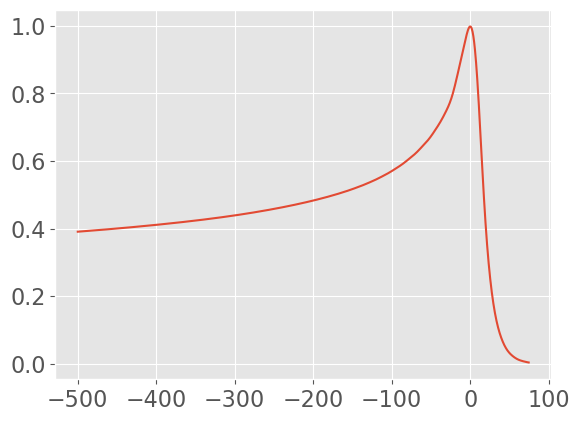

In [930]:
plt.figure()
plt.plot(training_data['times'], y[0])
plt.show()

In [931]:
def build_encoder(input_shape, latent_dim, units, acts):
    # build the encoder
    timeseries_input = keras.Input(shape=(input_shape,))
    for i, (unit, act) in enumerate(zip(units, acts)):
        if i == 0:
            x = layers.Dense(unit, activation=act)(timeseries_input)
        else:
            x = layers.Dense(unit, activation=act)(x)
    latent_output = layers.Dense(latent_dim)(x)
    encoder_model = keras.Model(timeseries_input, latent_output)
#     print("=" * 20)
#     print("encoder summary")
#     print("=" * 20)
#     encoder_model.summary()

    return encoder_model


def build_decoder(input_shape, latent_dim, units, acts):
    # build the decoder
    latent_input = keras.Input(shape=(latent_dim,))
    for i, (unit, act) in enumerate(zip(units, acts)):
        if i == 0:
            x = layers.Dense(unit, activation=act)(latent_input)
        else:
            x = layers.Dense(unit, activation=act)(x)
    timeseries_output = layers.Dense(input_shape, activation="linear")(x)
    decoder_model = keras.Model(latent_input, timeseries_output)
#     print("=" * 20)
#     print("decoder summary")
#     print("=" * 20)
#     decoder_model.summary()

    return decoder_model


def build_and_compile_autoencoder(
    input_shape, encoder_model, decoder_model, opt, loss, metrics
):
    # build the AE
    timeseries_input = keras.Input(shape=(input_shape,))
    latent = encoder_model(timeseries_input)
    timeseries_output = decoder_model(latent)
    ae_model = keras.Model(timeseries_input, timeseries_output)
#     print("=" * 20)
#     print("autoencoder summary")
#     print("=" * 20)
#     ae_model.summary()

    ae_model.compile(optimizer=opt, loss=loss, metrics=metrics)

    return ae_model




In [932]:
%%time
input_shape = y.shape[1]
latent_dim = 1
encoder_units = [128, 16]
encoder_acts = ['relu', 'relu']

# decoder_units = [16, 128]
# decoder_acts = ['relu', 'relu']

decoder_units = [16, 128, 128, 128]
decoder_acts = ['relu', 'relu', 'relu', 'relu']

loss = 'mae'
metrics = ['mse']

# opt = tf.keras.optimizers.Adam(1e-3)
boundaries = [5000, 5000]
values = [1e-3, 1e-4, 1e-5]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)
opt = tf.keras.optimizers.Adam(learning_rate_fn)


encoder_model = build_encoder(input_shape, latent_dim, encoder_units, encoder_acts)
decoder_model = build_decoder(input_shape, latent_dim, decoder_units, decoder_acts)
ae_model = build_and_compile_autoencoder(
    input_shape, encoder_model, decoder_model, opt, loss, metrics
)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

# history = ae_model.fit(y, y, epochs=10000, callbacks=callbacks, verbose=0, validation_data=(yval, yval))
# history = ae_model.fit(y, y, epochs=10000, callbacks=callbacks, verbose=0, validation_data=(yval, yval), batch_size=100)
history = ae_model.fit(y, y, epochs=10000, callbacks=callbacks, verbose=0, batch_size=100)


CPU times: user 4min 23s, sys: 1min 47s, total: 6min 11s
Wall time: 1min 40s


In [933]:
history.history.keys()

dict_keys(['loss', 'mse'])

In [934]:
plt.figure()
plt.plot(history.history['mse'])
# plt.plot(history.history['val_mse'])
plt.yscale('log')
plt.show()
plt.close()

In [935]:
# two outputs
index=-1
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(times, y[index])
plt.plot(times, ae_model.predict(y)[index])

plt.subplot(1, 2, 2)
plt.plot(times, y[index]-ae_model.predict(y)[index], label='first')
plt.legend()
plt.show()
plt.close()

In [936]:
yRes = y-ae_model.predict(y)
yRes_val = yval-ae_model.predict(yval)

In [937]:
%%time
input_shape = y.shape[1]
latent_dim = 1
encoder_units = [128, 16]
encoder_acts = ['relu', 'relu']

decoder_units = [16, 128]
decoder_acts = ['relu', 'relu']

# decoder_units = [16, 128, 128, 128]
# decoder_acts = ['relu', 'relu', 'relu', 'relu']

loss = 'mae'
metrics = ['mse']

opt = tf.keras.optimizers.Adam(1e-3)

encoder_model = build_encoder(input_shape, latent_dim, encoder_units, encoder_acts)
decoder_model = build_decoder(input_shape, latent_dim, decoder_units, decoder_acts)
ae_model_2 = build_and_compile_autoencoder(
    input_shape, encoder_model, decoder_model, opt, loss, metrics
)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

history_2 = ae_model_2.fit(yRes, yRes, epochs=1000, callbacks=callbacks, verbose=0, validation_data=(yRes_val, yRes_val), batch_size=10)


CPU times: user 2min 28s, sys: 29.7 s, total: 2min 58s
Wall time: 1min 31s


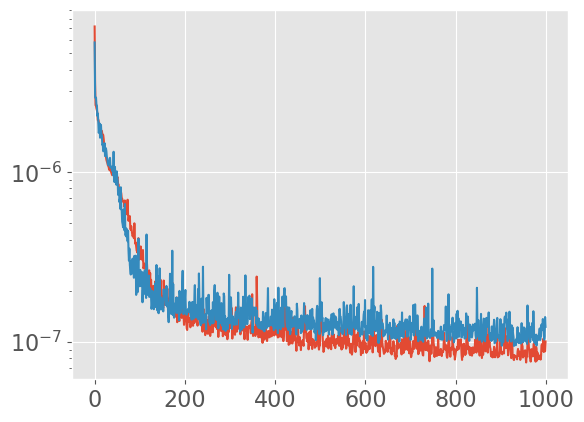

In [938]:
plt.figure()
plt.plot(history_2.history['mse'])
plt.plot(history_2.history['val_mse'])
plt.yscale('log')
plt.show()
plt.close()

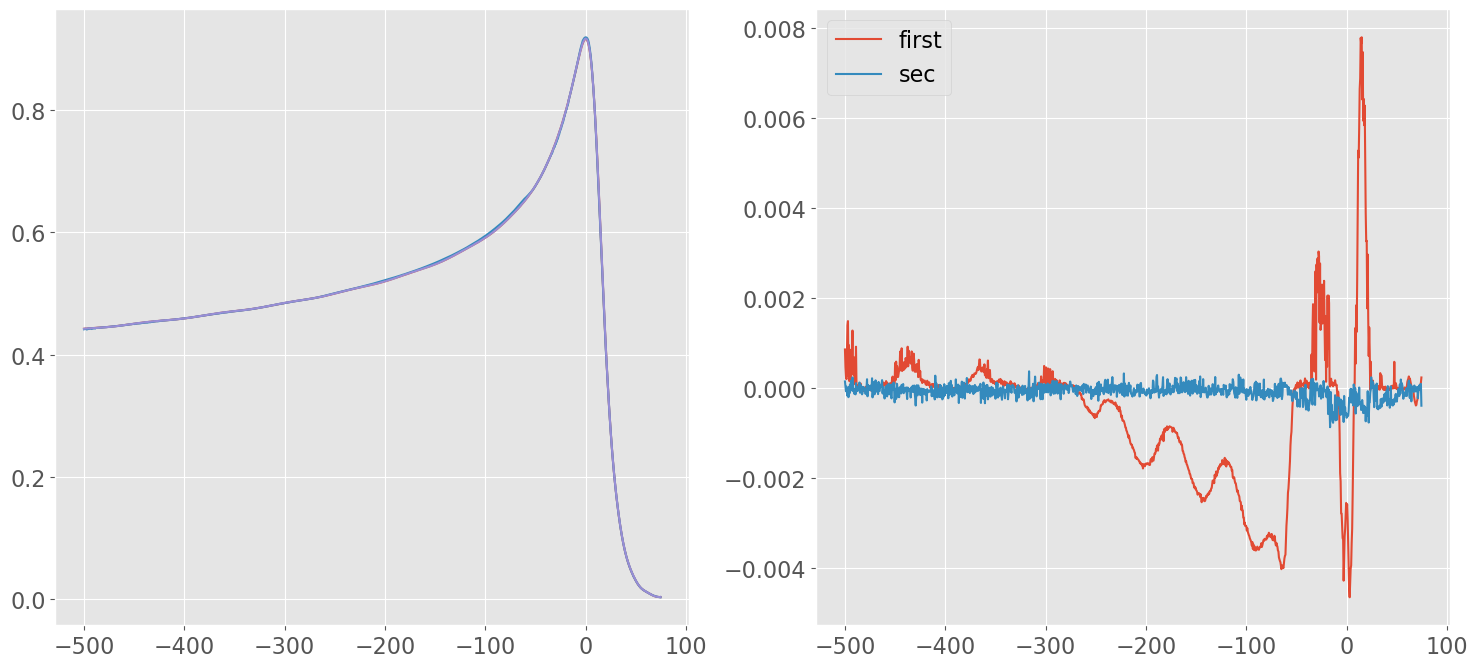

In [941]:
# two outputs
index=-1
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(times, y[index])
plt.plot(times, ae_model.predict(y)[index])

yhat_2 = ae_model.predict(y)[index] + ae_model_2.predict(yRes)[index]

plt.plot(times, yhat_2)

plt.subplot(1, 2, 2)
plt.plot(times, y[index]-ae_model.predict(y)[index], label='first')
plt.plot(times, y[index]-yhat_2, label='sec')
plt.legend()
plt.show()
plt.close()

# end to end

In [942]:
def make_model_3():
    timeseries_input = tf.keras.Input(shape=(input_shape,))

    x = tf.keras.layers.Dense(128, activation='relu')(timeseries_input)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='linear')(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    timeseries_output = tf.keras.layers.Dense(input_shape, activation='linear', name='output1')(x)

    subtracted_input = tf.keras.layers.subtract([timeseries_input, timeseries_output])

    x = tf.keras.layers.Dense(128, activation='relu')(subtracted_input)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    subtracted_output = tf.keras.layers.Dense(input_shape, activation='linear')(x)


    output_2 = tf.keras.layers.add([timeseries_output, subtracted_output], name='output2')

    subtracted_input_2 = tf.keras.layers.subtract([subtracted_input, subtracted_output])
    x = tf.keras.layers.Dense(128, activation='relu')(subtracted_input_2)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    subtracted_output_2 = tf.keras.layers.Dense(input_shape, activation='linear')(x)


    # final_output = tf.keras.layers.add([timeseries_output, subtracted_output], name='final_output')
    final_output = tf.keras.layers.add([timeseries_output, subtracted_output, subtracted_output_2], name='final_output')

    # model = tf.keras.Model(inputs=timeseries_input, outputs=[timeseries_output, final_output])
    model = tf.keras.Model(inputs=timeseries_input, outputs=[timeseries_output, output_2, final_output])
    
    return model

In [943]:
def make_model():
    timeseries_input = tf.keras.Input(shape=(input_shape,))

    x = tf.keras.layers.Dense(128, activation='relu')(timeseries_input)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='linear', name='latent_space')(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    timeseries_output = tf.keras.layers.Dense(input_shape, activation='linear', name='output1')(x)

    subtracted_input = tf.keras.layers.subtract([timeseries_input, timeseries_output])

    
    x = tf.keras.layers.Dense(128, activation='relu')(subtracted_input)
    
#     subtracted_input_stop = tf.keras.layers.Lambda(lambda x: tf.stop_gradient(x))(subtracted_input)
#     x = tf.keras.layers.Dense(128, activation='relu')(subtracted_input_stop)
    
#     x = tf.keras.layers.Dense(128, activation='relu')(tf.keras.layers.LayerNormalization()(subtracted_input))

    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    
#     x = tf.keras.layers.Dense(128, activation='relu')(x)
#     x = tf.keras.layers.Dense(128, activation='relu')(x)
#     x = tf.keras.layers.Dense(128, activation='relu')(x)
#     x = tf.keras.layers.Dense(128, activation='relu')(x)
#     x = tf.keras.layers.Dense(128, activation='relu')(x)
#     x = tf.keras.layers.Dense(128, activation='relu')(x)
#     x = tf.keras.layers.Dense(128, activation='relu')(x)
#     x = tf.keras.layers.Dense(128, activation='relu')(x)
#     x = tf.keras.layers.Dense(128, activation='relu')(x)
#     x = tf.keras.layers.Dense(16, activation='relu')(x)
#     x = tf.keras.layers.Dense(2, activation='linear')(x)
#     x = tf.keras.layers.Dense(16, activation='relu')(x)
#     x = tf.keras.layers.Dense(128, activation='relu')(x)

    subtracted_output = tf.keras.layers.Dense(input_shape, activation='linear')(x)

    final_output = tf.keras.layers.add([timeseries_output, subtracted_output], name='final_output')
    model = tf.keras.Model(inputs=timeseries_input, outputs=[timeseries_output, final_output])
    return model

In [944]:
y.shape

(300, 1150)

In [945]:
%%time

model = make_model()
# model = make_model_3()

# loss = 'mae'
loss = {'output1':'mae', 'final_output':'mae'}
# loss = {'output1':'mae', 'output1':'mae', 'final_output':'mae'}
metrics = ['mse']

# opt = tf.keras.optimizers.Adam(1e-3)

boundaries = [5000, 5100]
values = [1e-3, 1e-4, 1e-5]
# boundaries = [500, 600]
# values = [1e-3, 1e-4, 1e-5]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)
opt = tf.keras.optimizers.Adam(learning_rate_fn)

model.compile(optimizer=opt, loss=loss, metrics=metrics)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

# history = ae_model.fit(y, y, epochs=10000, callbacks=callbacks, verbose=0, validation_data=(yval, yval))

# history = model.fit(y, {'output1':y, 'final_output':y}, epochs=10000, callbacks=callbacks, verbose=0, batch_size=100) #, validation_data=(yval, yval))


# this is good
history = model.fit(y, {'output1':y, 'final_output':y}, epochs=10000, callbacks=callbacks, verbose=0, batch_size=100, validation_data=(yval, {'output1': yval, "final_output": yval}), validation_freq=100)



# {'output1':(yval, yval), 'final_output':(yval, yval)}



# history = model.fit(y, {'output1':y, 'output2':y, 'final_output':y}, epochs=5000, callbacks=callbacks, verbose=0) #, validation_data=(yval, yval))


CPU times: user 8min 29s, sys: 2min 57s, total: 11min 26s
Wall time: 3min 12s


In [799]:
# tf.keras.utils.plot_model(model)

In [983]:
%%time
opt = tf.keras.optimizers.Adam(1e-4)

# model.compile(optimizer=opt, loss=loss, metrics=metrics)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

# history = ae_model.fit(y, y, epochs=10000, callbacks=callbacks, verbose=0, validation_data=(yval, yval))

#this is good
history = model.fit(y, {'output1':y, 'final_output':y}, epochs=1000, callbacks=callbacks, verbose=0, batch_size=100, validation_data=(yval, {'output1': yval, "final_output": yval}), validation_freq=100)



# history = model.fit(y, {'output1':y, 'output2':y, 'final_output':y}, epochs=5000, callbacks=callbacks, verbose=0) #, validation_data=(yval, yval))


CPU times: user 51.4 s, sys: 18.4 s, total: 1min 9s
Wall time: 20.4 s


In [984]:
# https://stackoverflow.com/questions/48547688/tensorflow-keras-copy-weights-from-one-model-to-another
# clone_model doesn't copy the weights
model_clone = tf.keras.models.clone_model(model)
model_clone.set_weights(model.get_weights())

In [985]:
history.history.keys()

dict_keys(['loss', 'output1_loss', 'final_output_loss', 'output1_mse', 'final_output_mse', 'val_loss', 'val_output1_loss', 'val_final_output_loss', 'val_output1_mse', 'val_final_output_mse'])

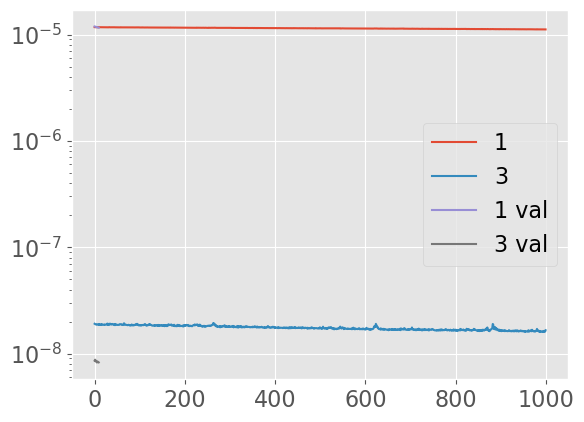

In [986]:
plt.figure()
# plt.plot(history.history['mse'])
# plt.plot(history.history['val_mse'])|
plt.plot(history.history['output1_mse'], label='1')
# plt.plot(history.history['output2_mse'], label='2')
plt.plot(history.history['final_output_mse'], label='3')


plt.plot(history.history['val_output1_mse'], label='1 val')
plt.plot(history.history['val_final_output_mse'], label='3 val')

# plt.plot(history.history['output1_loss'])
# plt.plot(history.history['final_output_loss'])
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

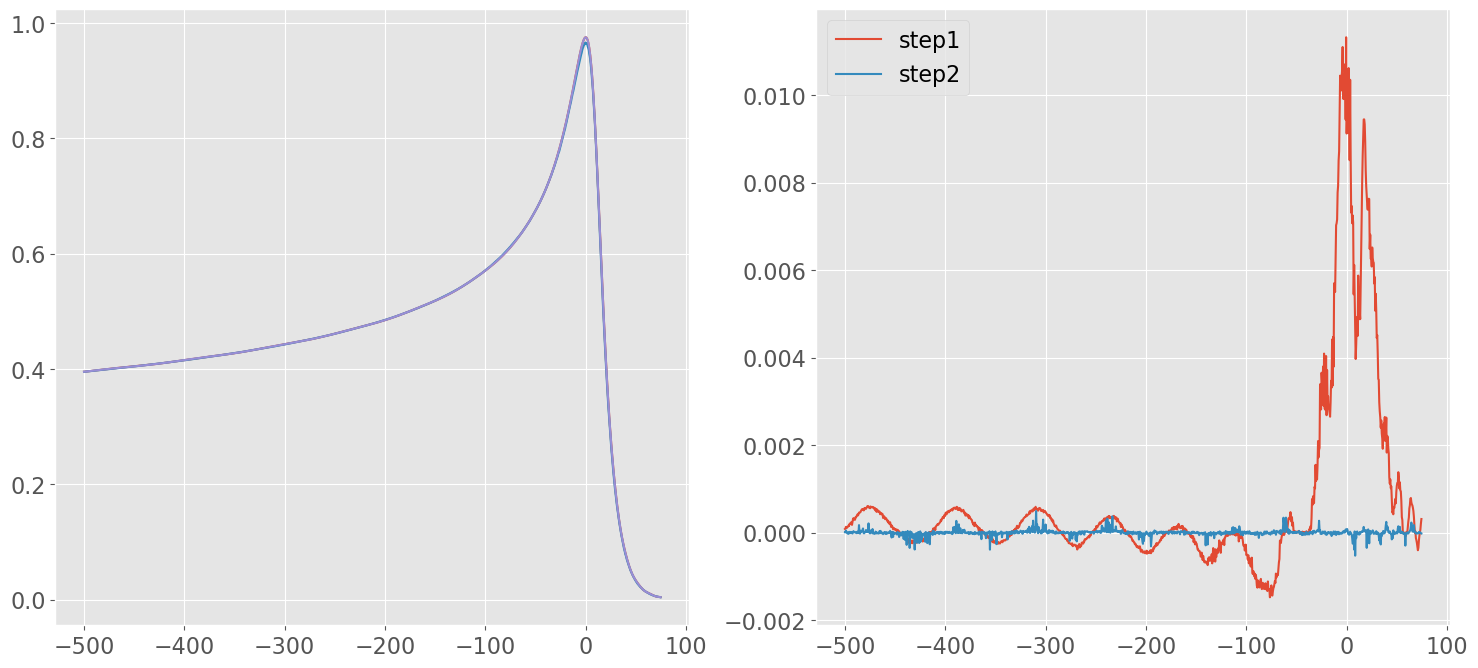

In [991]:
# two outputs
index=-4
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(times, y[index])
plt.plot(times, model.predict(y)[0][index])
plt.plot(times, model.predict(y)[1][index])
# plt.plot(times, model.predict(y)[2][index])

plt.subplot(1, 2, 2)
plt.plot(times, y[index]-model.predict(y)[0][index], label='step1')
plt.plot(times, y[index]-model.predict(y)[1][index], label='step2')
# plt.plot(times, y[index]-model.predict(y)[2][index], label='step3')
plt.legend()
plt.show()
plt.close()

In [952]:
# freeze encoder and continue training for smaller learning rate

In [993]:
model_clone.summary()

Model: "model_83"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_81 (InputLayer)           [(None, 1150)]       0                                            
__________________________________________________________________________________________________
dense_549 (Dense)               (None, 128)          147328      input_81[0][0]                   
__________________________________________________________________________________________________
dense_550 (Dense)               (None, 16)           2064        dense_549[0][0]                  
__________________________________________________________________________________________________
latent_space (Dense)            (None, 1)            17          dense_550[0][0]                  
___________________________________________________________________________________________

In [994]:
# freeze the layers you want
for layer in model_clone.layers[:8]:
    layer.trainable = False

In [995]:
model_clone.layers[6].trainable

False

In [996]:
model_clone.layers[7].trainable

False

In [997]:
model_clone.layers[8].trainable

True

In [998]:
model_clone.layers[8].name

'dense_553'

In [1059]:
%%time
loss = {'output1':'mae', 'final_output':'mae'}
metrics = ['mse']
opt = tf.keras.optimizers.Adam(1e-5)
model_clone.compile(optimizer=opt, loss=loss, metrics=metrics)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

history_clone = model_clone.fit(y, {'output1':y, 'final_output':y}, epochs=8000, callbacks=callbacks, verbose=0, batch_size=10, validation_data=(yval, {'output1': yval, "final_output": yval}) , validation_freq=100)


CPU times: user 13min 10s, sys: 2min 49s, total: 16min
Wall time: 5min 38s


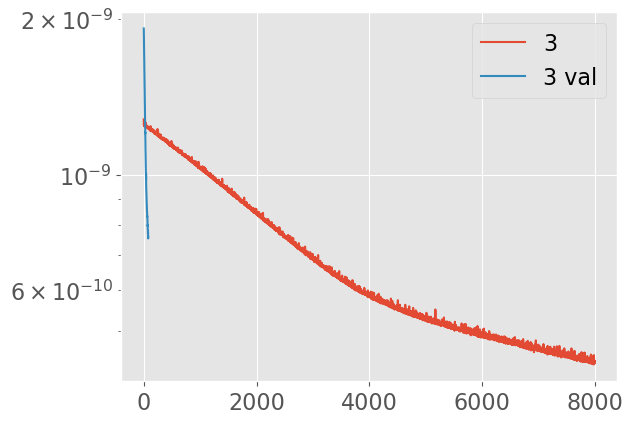

In [1060]:
plt.figure()
# plt.plot(history.history['mse'])
# plt.plot(history.history['val_mse'])
# plt.plot(history.history['output1_mse'], label='1')
# plt.plot(history.history['output2_mse'], label='2')
plt.plot(history_clone.history['final_output_mse'], label='3')
plt.plot(history_clone.history['val_final_output_mse'], label='3 val')
# plt.plot(history.history['output1_loss'])
# plt.plot(history.history['final_output_loss'])
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

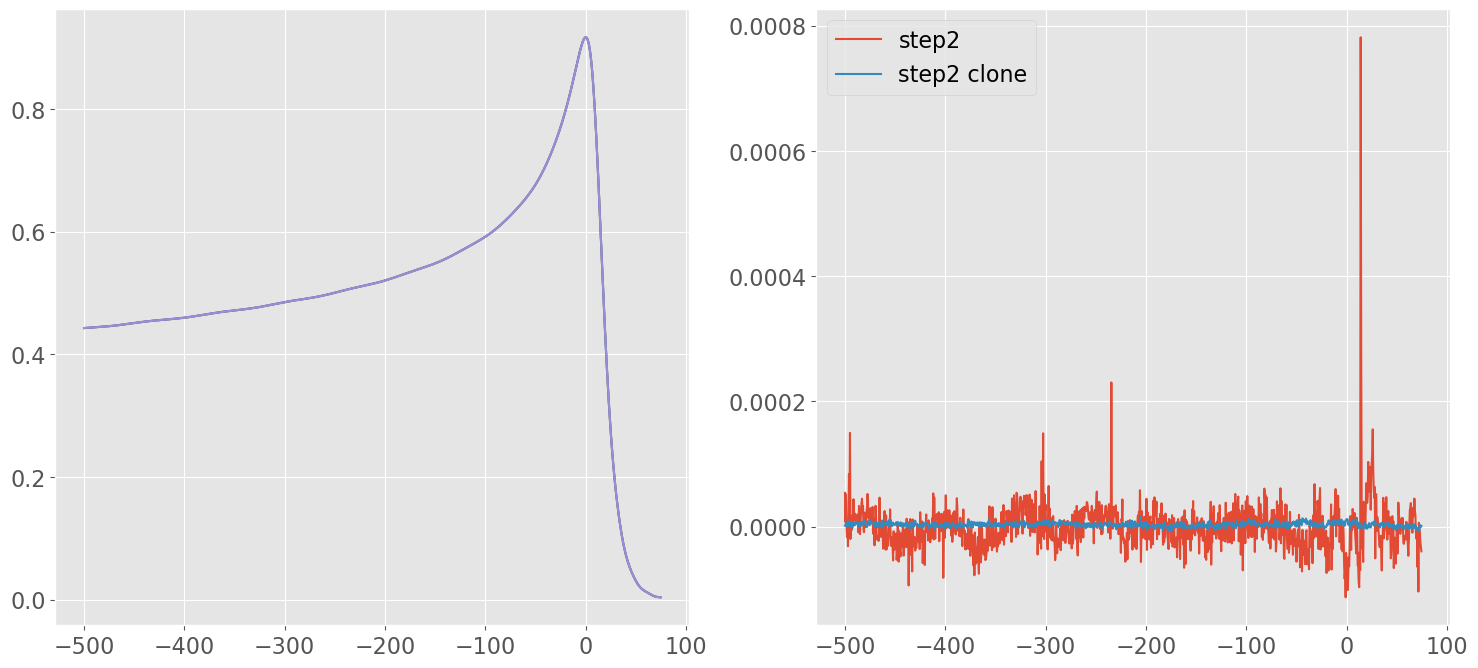

In [1062]:
# two outputs
index=-1
# index=0
# index=5
# index=3
# index=198
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(times, y[index])
# plt.plot(times, model.predict(y)[0][index])
plt.plot(times, model.predict(y)[1][index])
plt.plot(times, model_clone.predict(y)[1][index])
# plt.plot(times, model.predict(y)[2][index])

plt.subplot(1, 2, 2)
# plt.plot(times, y[index]-model.predict(y)[0][index], label='step1')
plt.plot(times, y[index]-model.predict(y)[1][index], label='step2')
plt.plot(times, y[index]-model_clone.predict(y)[1][index], label='step2 clone')
# plt.plot(times, y[index]-model.predict(y)[2][index], label='step3')
plt.legend()
plt.show()
plt.close()

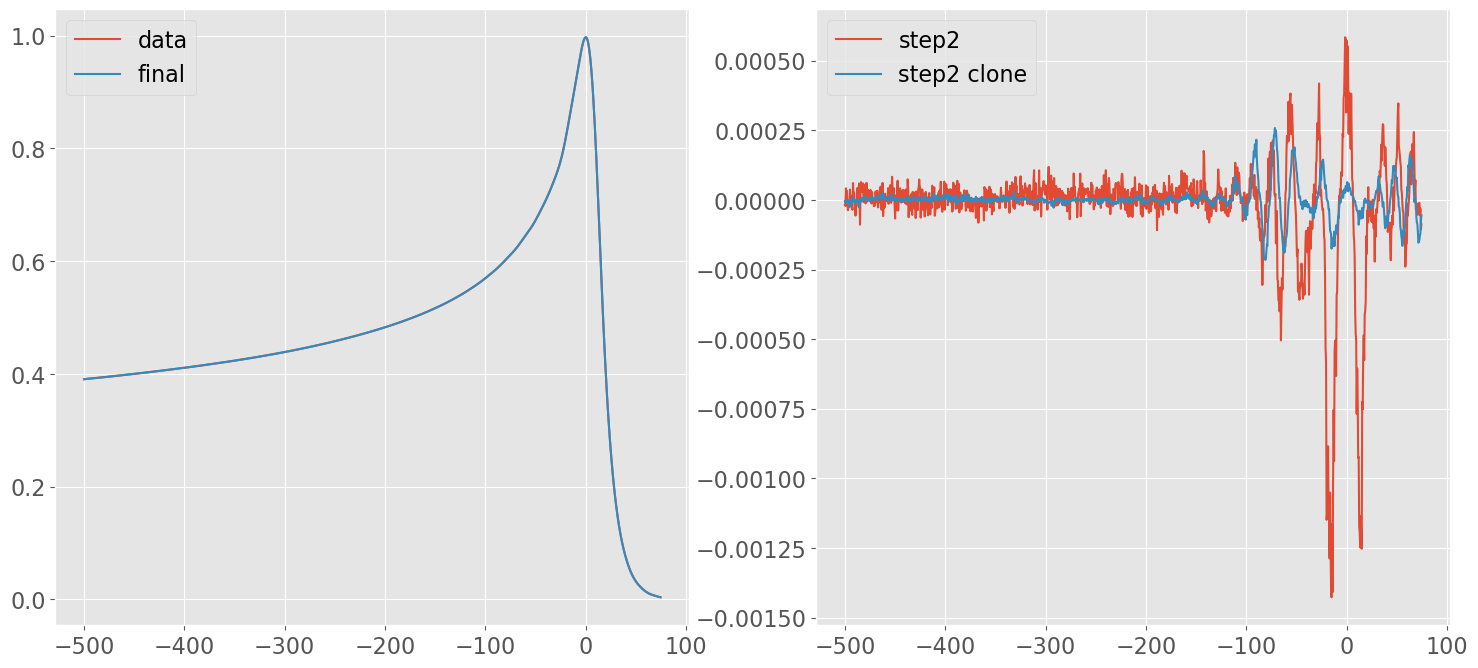

In [1063]:
# two outputs
index=2
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(times, yval[index], label='data')
# plt.plot(times, model.predict(yval)[0][index])
# plt.plot(times, model.predict(yval)[1][index])
plt.plot(times, model_clone.predict(yval)[1][index], label='final')
# plt.plot(times, model.predict(yval)[2][index])
plt.legend()

plt.subplot(1, 2, 2)
# plt.plot(times, yval[index]-model.predict(yval)[0][index], label='step1')
plt.plot(times, yval[index]-model.predict(yval)[1][index], label='step2')
plt.plot(times, yval[index]-model_clone.predict(yval)[1][index], label='step2 clone')
# plt.plot(times, yval[index]-model.predict(yval)[2][index], label='step3')
plt.legend()
plt.show()
plt.close()

In [1064]:
# check latent space by getting output from hidden layer
# to do this clone the model and copy weights
# then make a new model with the same input but
# set the output equal to the latent space layer

# https://stackoverflow.com/a/49689175/12840171

In [1065]:
model_clone_latent = tf.keras.models.clone_model(model_clone)
model_clone_latent.set_weights(model_clone.get_weights()) 

In [1066]:
for i, layer in enumerate(model_clone_latent.layers):
    print(i, layer.name)

0 input_81
1 dense_549
2 dense_550
3 latent_space
4 dense_551
5 dense_552
6 output1
7 subtract_50
8 dense_553
9 dense_554
10 dense_555
11 dense_556
12 final_output


In [1067]:
model_clone_latent.get_layer(name='latent_space')

In [1068]:
model_clone_latent.layers[3].name

'latent_space'

In [1069]:
model_latent = tf.keras.Model(inputs=model_clone_latent.input, outputs=model_clone_latent.get_layer(name='latent_space').output)

In [1070]:
model_latent.predict(y).shape

(300, 1)

In [1071]:
latent_space = model_latent.predict(y)
latent_space_val = model_latent.predict(yval)

In [1072]:
x.shape

(300,)

In [1080]:
plt.figure()

for name in training_data['unique_approximants']:
    mask = training_data['mask'][name]
    plt.plot(x[mask], latent_space[:,0][mask], '-', label=name)
plt.legend()
plt.show()
plt.close()

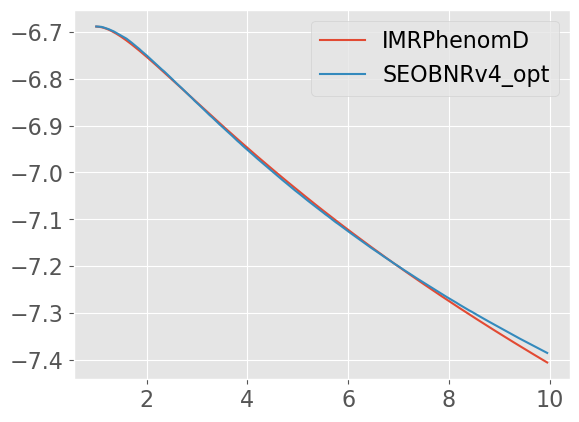

In [1082]:
plt.figure()

for name in validation_data['unique_approximants']:
    mask = validation_data['mask'][name]
    plt.plot(xval[mask], latent_space_val[:,0][mask], '-', label=name)
plt.legend()
plt.show()
plt.close()

# probably obsolete

In [1017]:
yRes = y-(model.predict(y)[1])

In [1018]:
%%time

model_2 = make_model()

# loss = 'mae'
loss = {'output1':'mae', 'final_output':'mae'}
# loss = {'output1':'mae', 'output1':'mae', 'final_output':'mae'}
metrics = ['mse']

opt = tf.keras.optimizers.Adam(1e-5)

model_2.compile(optimizer=opt, loss=loss, metrics=metrics)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

history_2 = model_2.fit(y, {'output1':yRes, 'final_output':yRes}, epochs=3000, callbacks=callbacks, verbose=0) #, validation_data=(yval, yval))



CPU times: user 4min 17s, sys: 54.2 s, total: 5min 12s
Wall time: 1min 40s


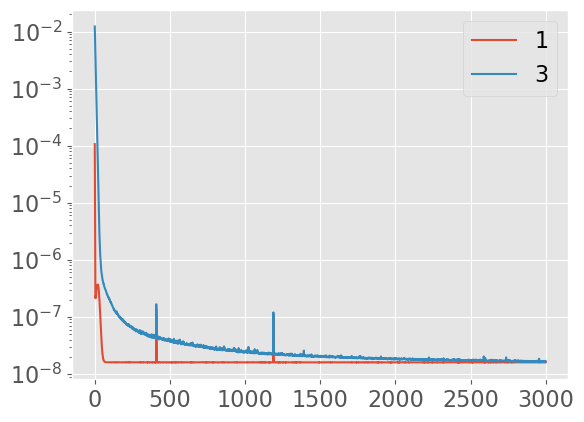

In [1019]:
plt.figure()
plt.plot(history_2.history['output1_mse'], label='1')
plt.plot(history_2.history['final_output_mse'], label='3')
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

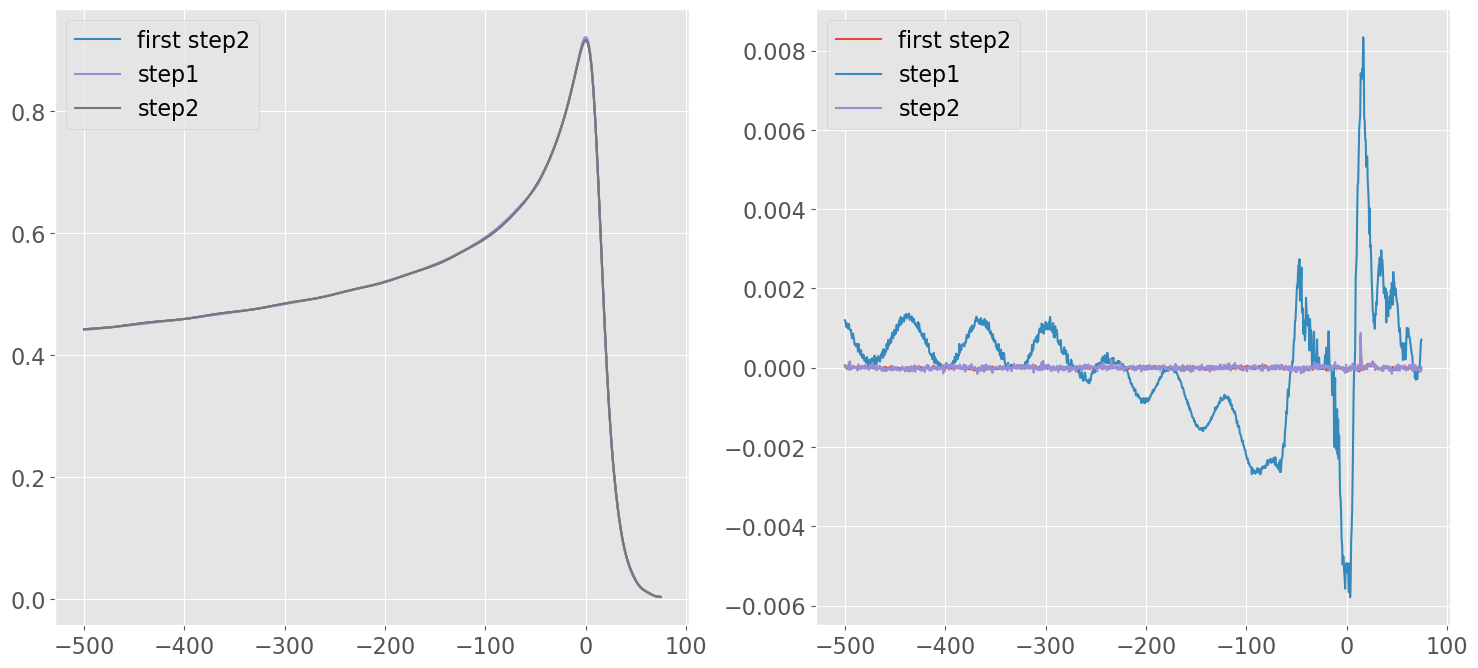

In [1022]:
# two outputs
index=-1


yhat0 = model.predict(y)[0][index]+model_2.predict(y)[0][index]
yhat1 = model.predict(y)[1][index]+model_2.predict(y)[1][index]

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(times, y[index])
plt.plot(times, model.predict(y)[1][index], label='first step2')
plt.plot(times, yhat0, label='step1')
plt.plot(times, yhat1, label='step2')
plt.legend()


plt.subplot(1, 2, 2)

plt.plot(times, y[index]-model.predict(y)[1][index], label='first step2')

plt.plot(times, y[index]-yhat0, label='step1')
plt.plot(times, y[index]-yhat1, label='step2')
# plt.plot(times, y[index]-model.predict(y)[2][index], label='step3')
plt.legend()
plt.show()
plt.close()